In [53]:
%pip install xgboost missingno

Note: you may need to restart the kernel to use updated packages.


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.4f' % x)
pd.set_option('display.width', 500)

In [56]:
data_frame = pd.read_excel("NAFLD.xlsx")

In [57]:
#Genel bakış
def data_f_check(dataframe, head=10):
    print("*******************************")
    print(dataframe.shape)
    print("*******************************")
    print(dataframe.dtypes)
    print("*******************************")
    print(dataframe.isnull().sum())
    print("*******************************")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
data_f_check(data_frame)

*******************************
(605, 62)
*******************************
Patient No.                                                                                      int64
Age                                                                                              int64
Gender (Female=1, Male=2)                                                                        int64
Height                                                                                           int64
Weight                                                                                           int64
Body Mass Index                                                                                float64
Waist Circumference                                                                            float64
Hip Circumference                                                                              float64
Systolic Blood Pressure                                                                          int64

In [58]:
#Veri setindeki numerik ve kategorik kardinal değişkenlerin isimlerini veren fonksiyon.
def column_names_gr(dataframe, ctth=20, crth=30):
    """
    ctth: numerik değişkenlerin kategorik olup olmadığını belirleyen eşik 
    crth: kategorik değişkenlerin kardinalitesini belirleyen eşik 
    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes != 'O') and
    (dataframe[col].nunique() < ctth))]
    
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') and
    (dataframe[col].nunique() > crth))]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if col not in "Patient No."]
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = column_names_gr(data_frame)

In [59]:
#Analizi
def c_summry(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
for column in cat_cols:
    c_summry(data_frame, column)

                           Gender (Female=1, Male=2)   Ratio
Gender (Female=1, Male=2)                                   
2                                                321 53.0579
1                                                284 46.9421
                                  Diyabetes Mellitus (No=0, Yes=1)   Ratio
Diyabetes Mellitus (No=0, Yes=1)                                          
0                                                              380 62.8099
1                                                              225 37.1901
                            Hypertension (No=0, Yes=1)   Ratio
Hypertension (No=0, Yes=1)                                    
0                                                  391 64.6281
1                                                  214 35.3719
                              Hyperlipidemia (No=0, Yes=1)   Ratio
Hyperlipidemia (No=0, Yes=1)                                      
1                                                      351 58.0165
0  

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


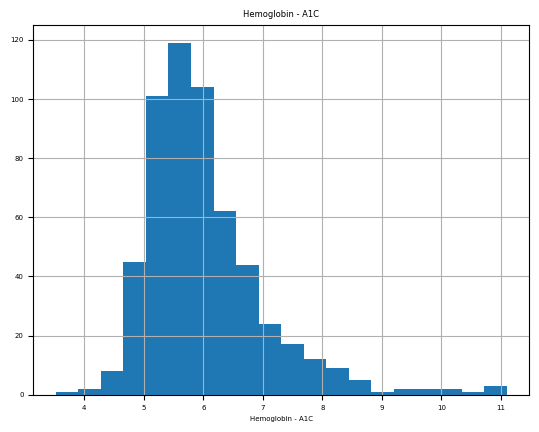

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


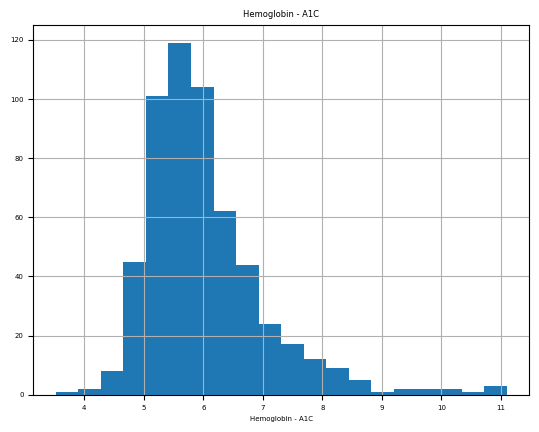

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


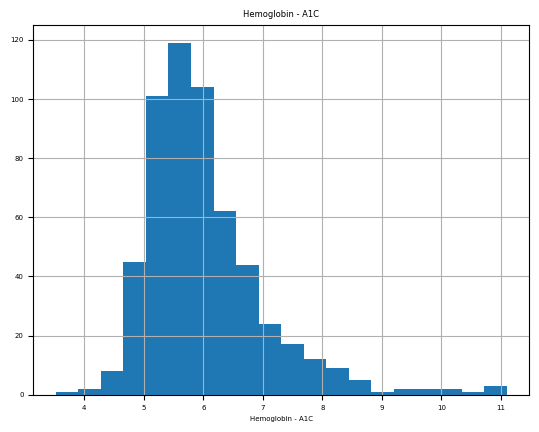

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


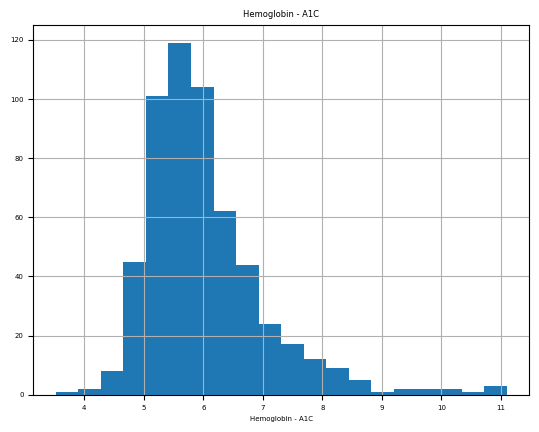

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


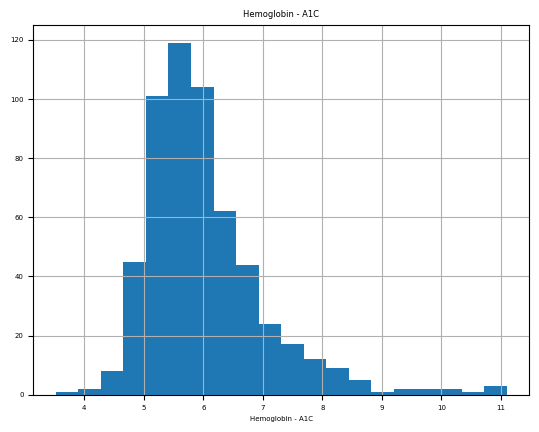

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


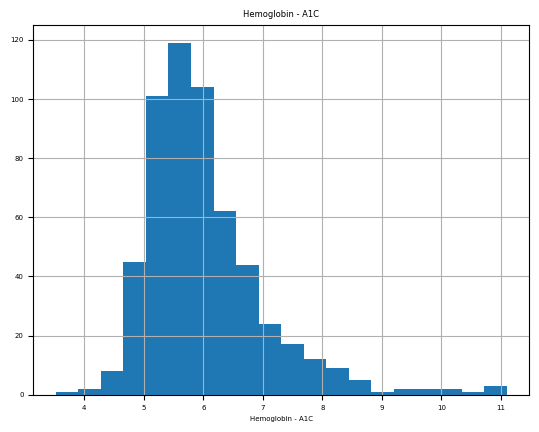

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


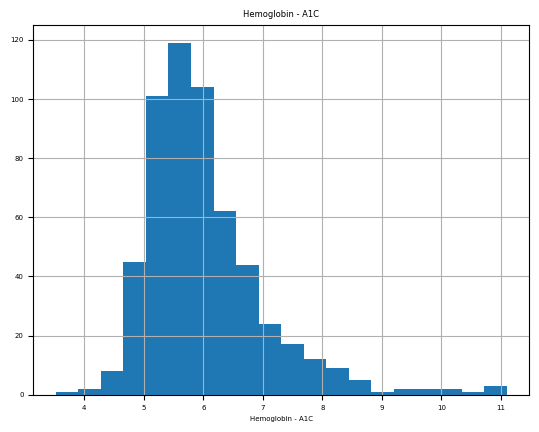

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


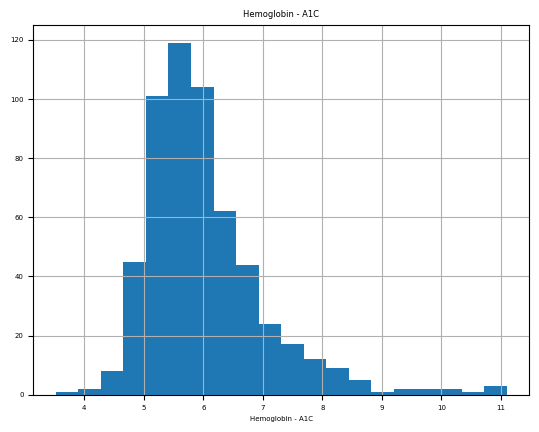

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


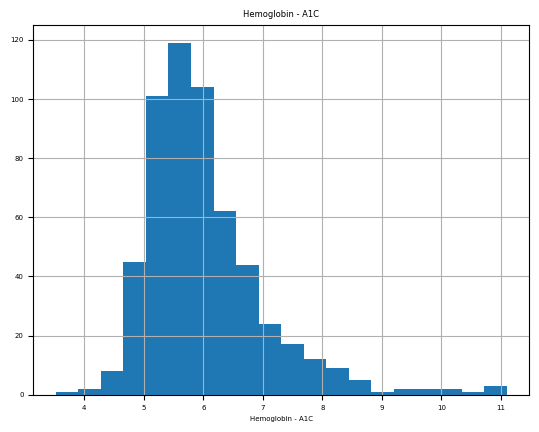

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


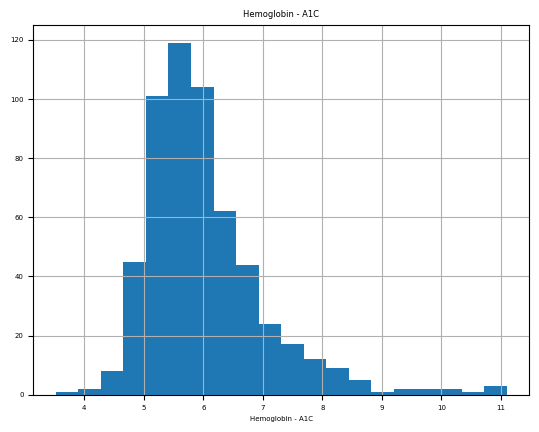

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


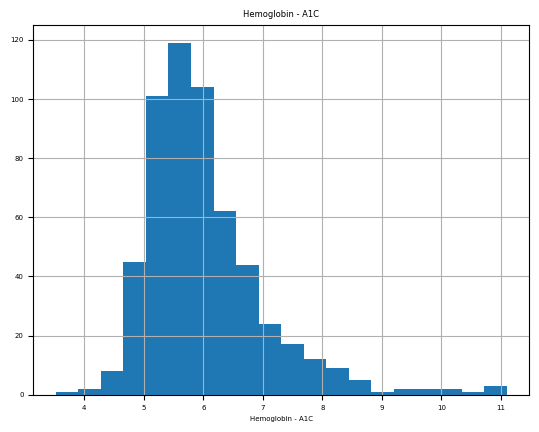

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


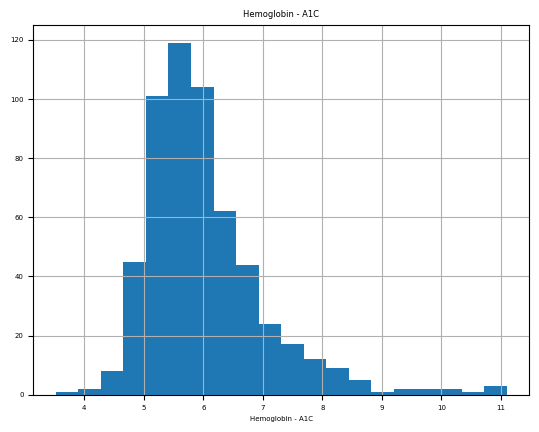

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


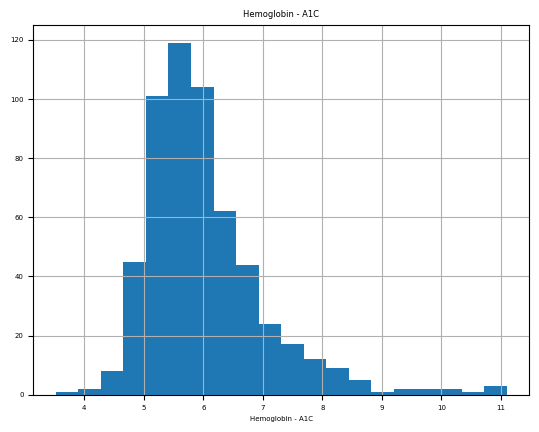

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


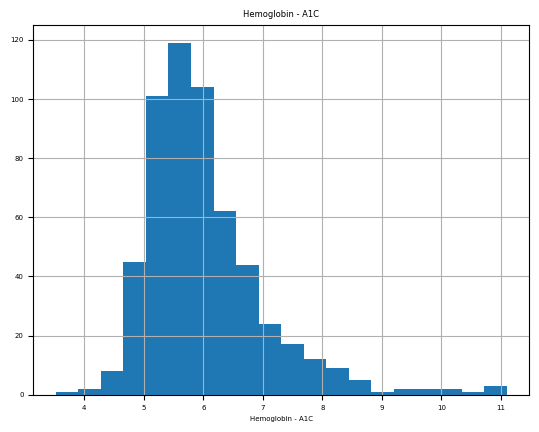

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


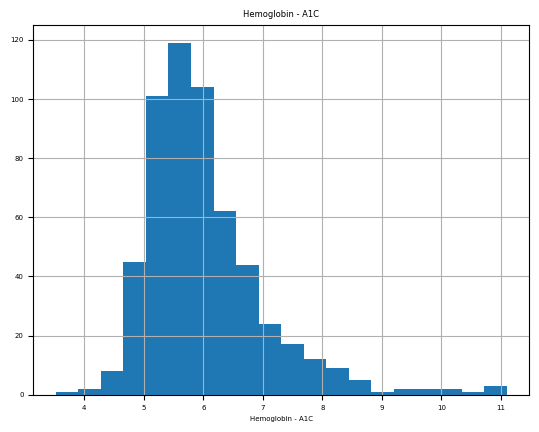

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


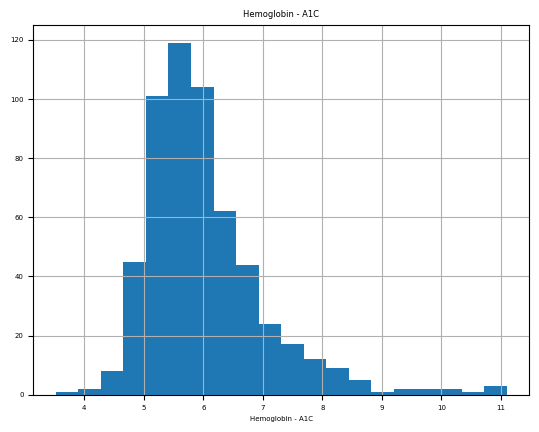

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


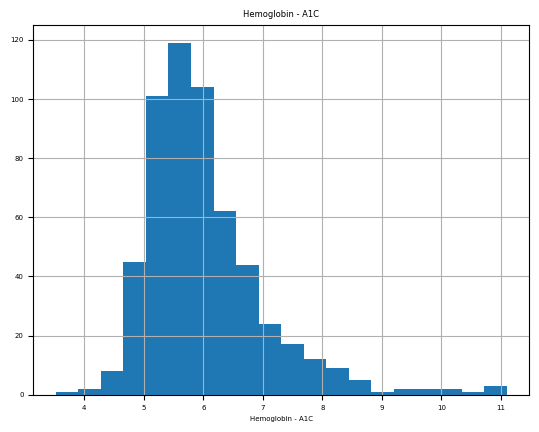

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


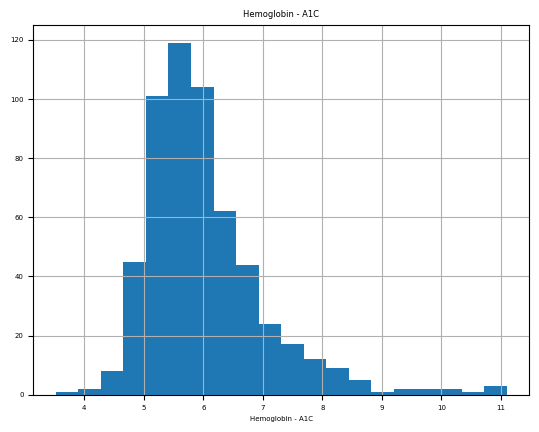

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


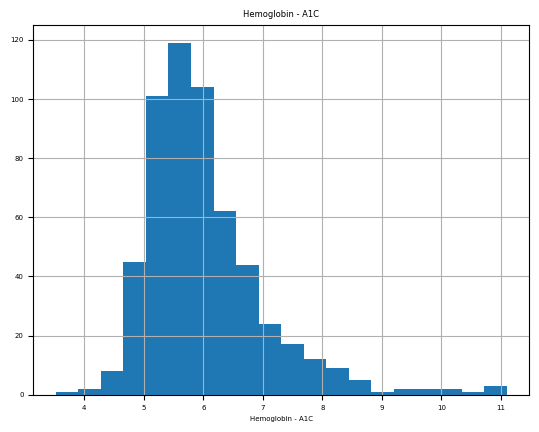

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


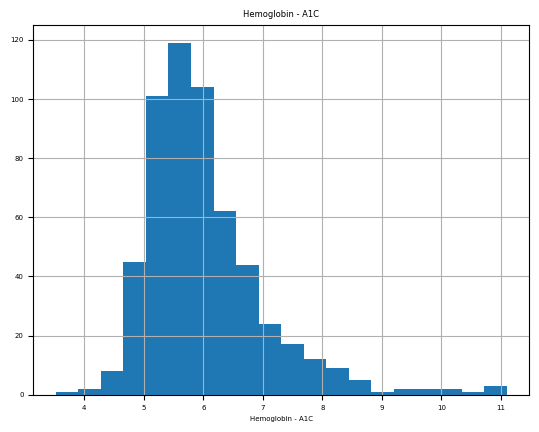

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


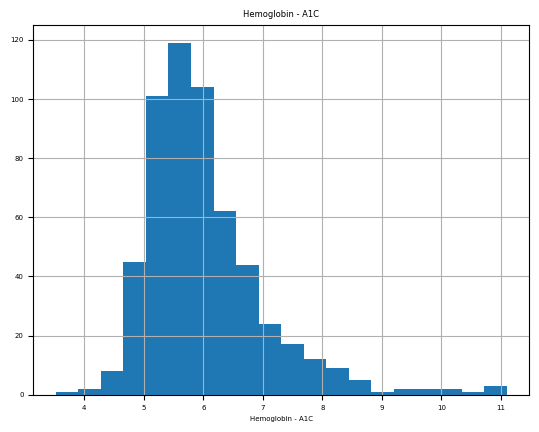

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


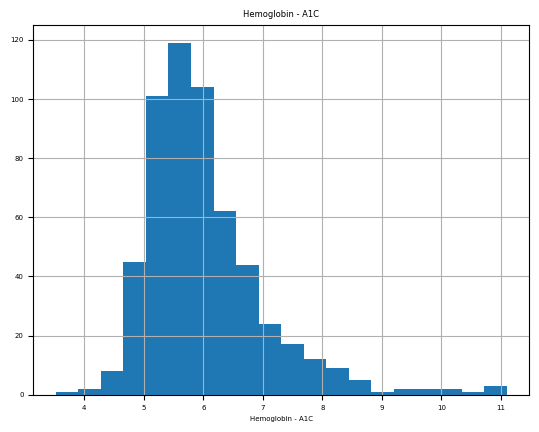

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


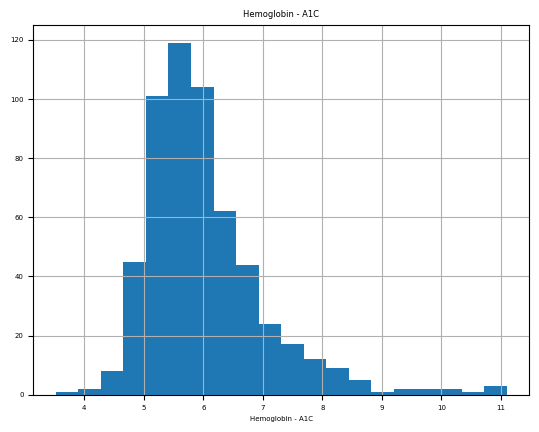

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


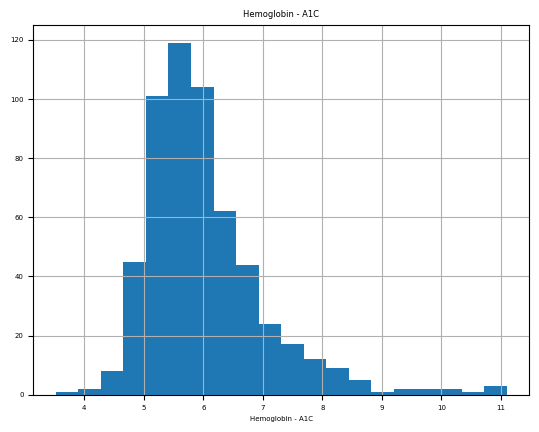

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


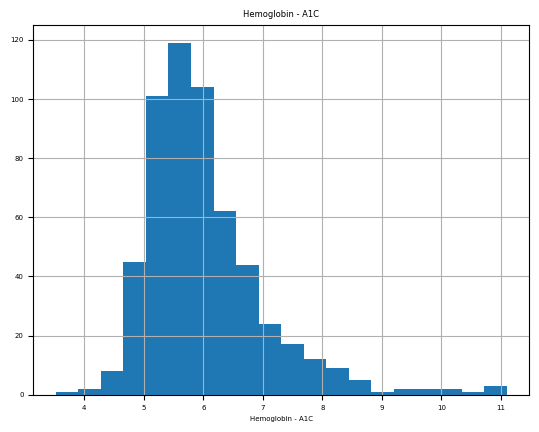

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


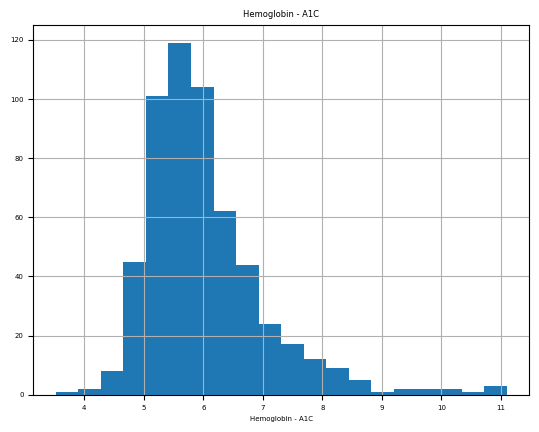

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


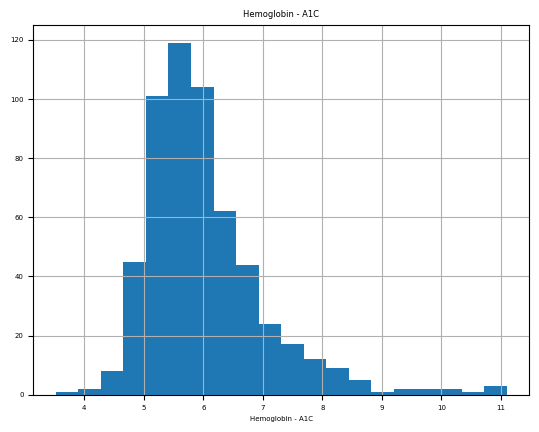

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


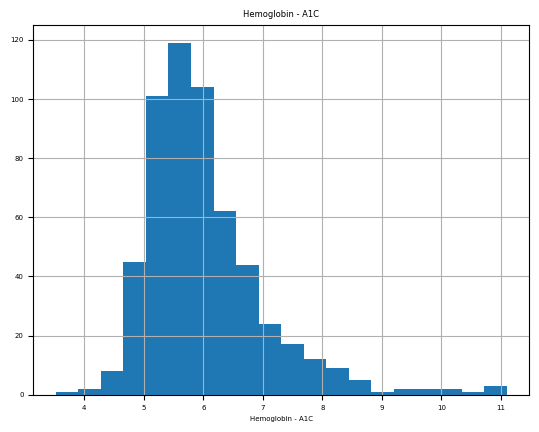

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


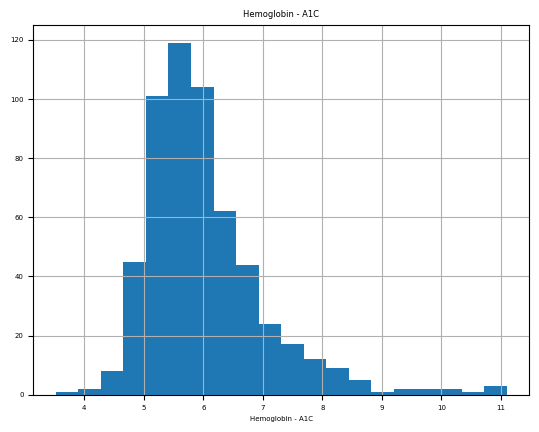

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


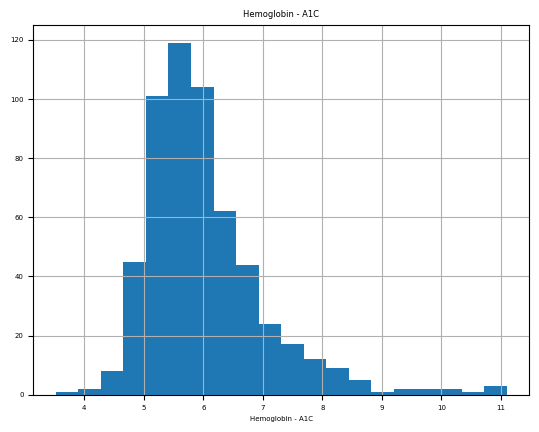

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


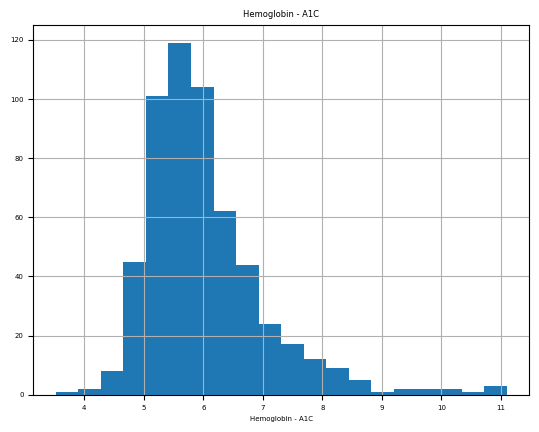

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


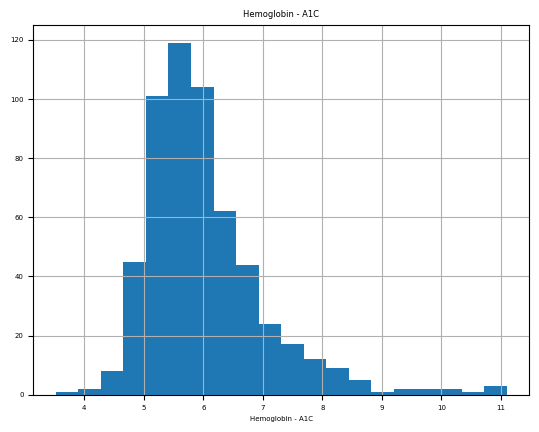

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


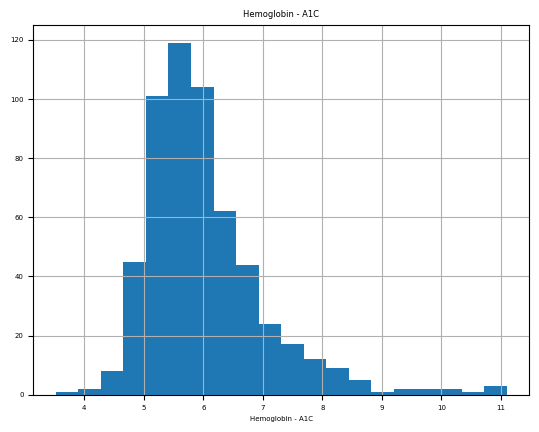

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


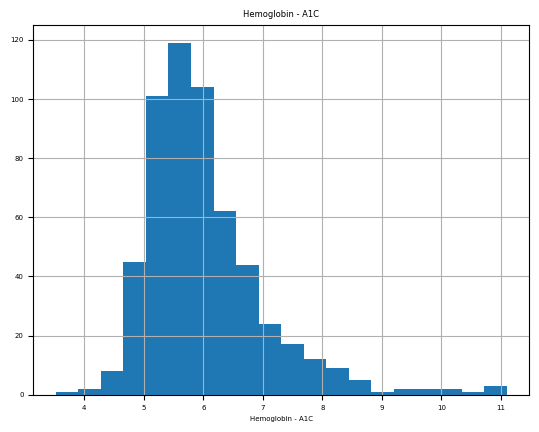

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


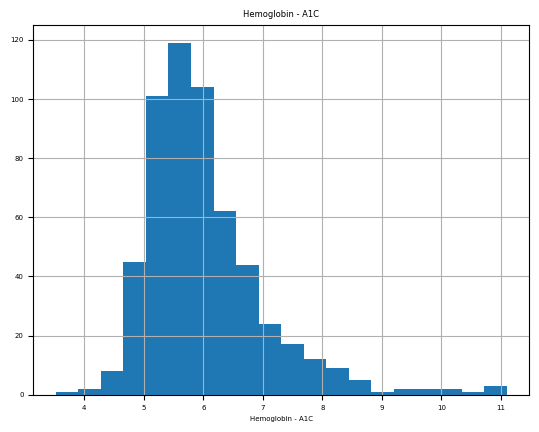

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


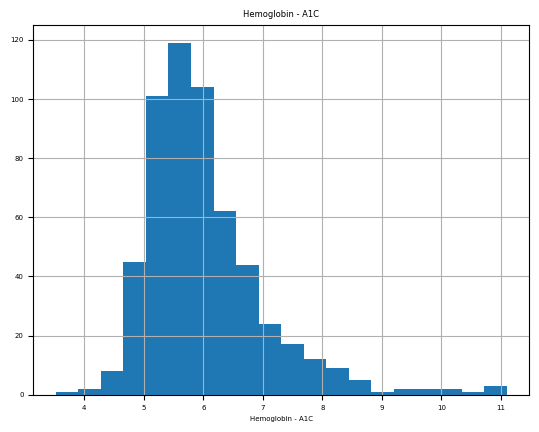

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


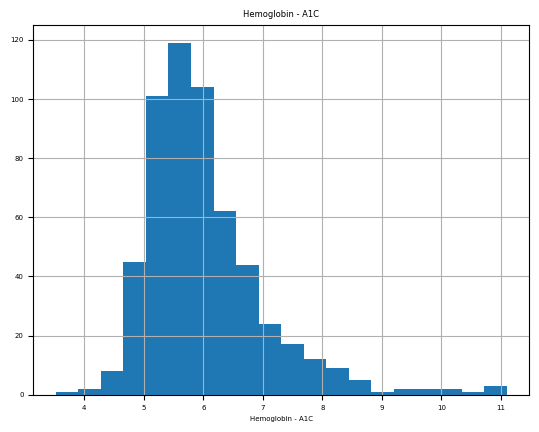

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


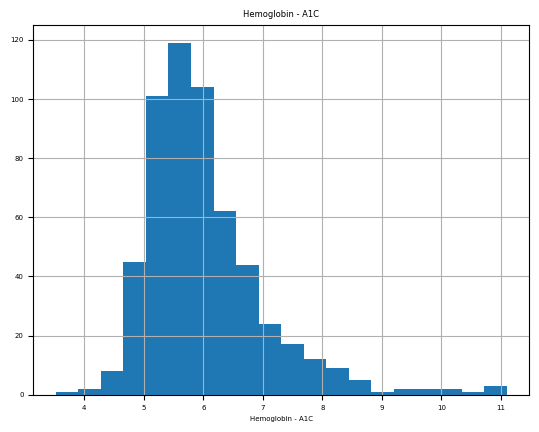

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


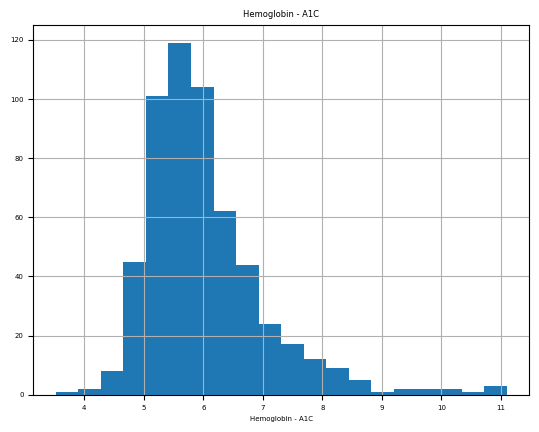

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


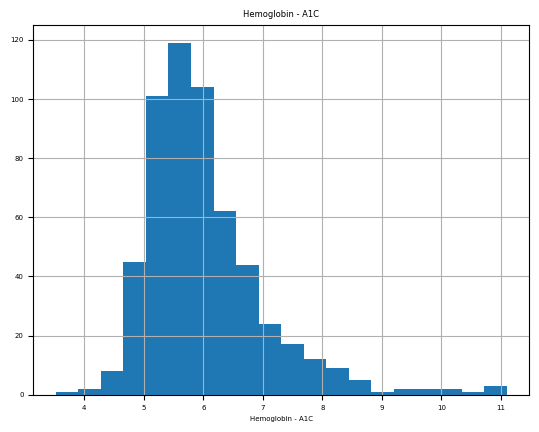

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


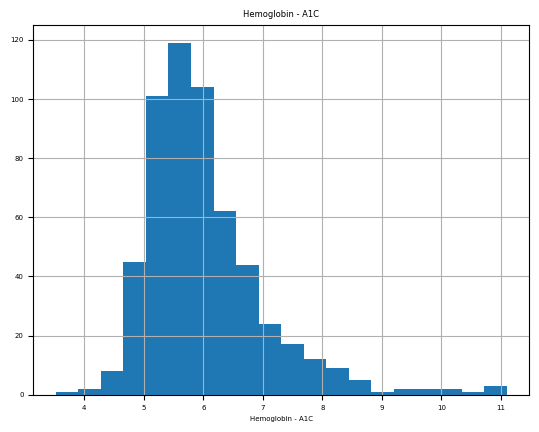

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


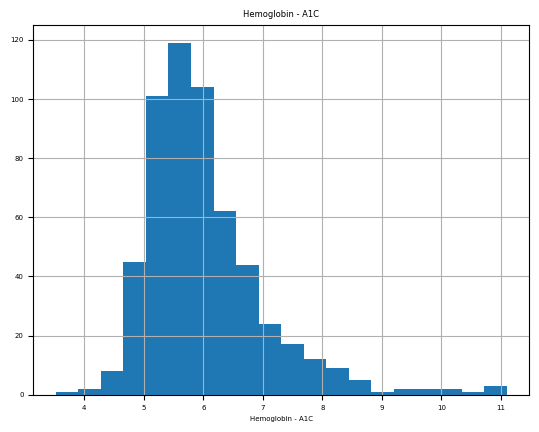

count   564.0000
mean      6.0158
std       1.0090
min       3.5200
5%        4.8730
10%       5.0430
20%       5.3340
30%       5.5000
40%       5.6000
50%       5.8000
60%       6.0000
70%       6.2000
80%       6.6000
90%       7.3000
95%       7.9000
99%       9.9370
100%     11.1000
max      11.1000
Name: Hemoglobin - A1C, dtype: float64


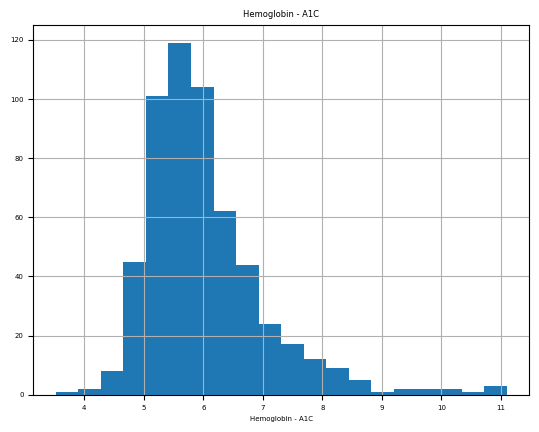

In [60]:
def nm_smmry(dataframe, number_column, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[number_column].describe(quantiles).T)
    if plot:
        dataframe[number_column].hist(bins=20)
        plt.xlabel(number_column)
        plt.title(number_column)
        plt.show()
for column in num_cols:
    nm_smmry(data_frame, col, True)

In [61]:
#Hedef değişken analizi
def trget_anlysis_numbr(dataframe, target, num_col):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n")    
for col in num_cols:
    trget_anlysis_numbr(data_frame, "Type of Disease (Mild illness=1, Severe illness=2)", col)

                                                       Age
Type of Disease (Mild illness=1, Severe illness=2)        
1                                                  46.5424
2                                                  46.2766


                                                     Height
Type of Disease (Mild illness=1, Severe illness=2)         
1                                                  165.4068
2                                                  164.7234


                                                    Weight
Type of Disease (Mild illness=1, Severe illness=2)        
1                                                  82.9322
2                                                  86.7784


                                                    Body Mass Index
Type of Disease (Mild illness=1, Severe illness=2)                 
1                                                           30.2907
2                                                           32.0392


        

In [62]:
#Korelasyon matrisi
data_frame.corr()

,Patient No.,Age,"Gender (Female=1, Male=2)",Height,Weight,Body Mass Index,Waist Circumference,Hip Circumference,Systolic Blood Pressure,Diastolic Blood Pressure,"Diyabetes Mellitus (No=0, Yes=1)","Hypertension (No=0, Yes=1)","Hyperlipidemia (No=0, Yes=1)","Metabolic syndrome (No=0, Yes=1)","Smoking Status (Never Smoked=1, Left Smoking=2, Smoking=3)",AST,ALT,ALP,GGT,LDH,Total Bilirubin,Direct Bilirubin,Total Protein,Albumin,Total Cholesterol,Triglycerides,HDL,LDL,Microalbumin Spot Urine,Microalbumin/Creatinine Ratio,TSH,CK,Leukocyte,Hemoglobin,Trombosit,Mean Corpuscular Volume,Mean Platelet Volume,PT,INR,Vitamin D,Ferritin,Ceruloplasmin,C Peptide,Glucose,Insulin,HOMA,"Insulin resistance according to HOMA (insulin resistance = 1, no insulin resistance = 2)",Uric Acid,BUN,Creatinine,Hemoglobin - A1C,Steatosis,Activity,Fibrosis,NAS score according to Kleiner,"NAS score>=4 and Fibrosis>=2 (If NAS score>=4 and Fibrosis>=2 = 1, If not = 0)","Fibrosis status (No=0, Yes=1) (Fibrosis 1 and above, there is Fibrosis)","Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)","Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)","Cirrhosis (No=0, Yes=1) (If Fibrosis is 4, there is Cirrhosis)","Diagnosis according to SAF (NASH=1, NAFL=2)","Type of Disease (Mild illness=1, Severe illness=2)"
Patient No.,1.0000,0.0904,-0.0532,-0.0791,-0.0315,0.0332,0.0026,-0.0647,-0.0335,-0.0175,-0.0188,0.0645,-0.0426,0.0094,0.0054,0.0169,-0.0231,0.0623,0.0455,-0.0951,-0.1791,-0.1642,0.0426,-0.0741,0.0531,0.0285,0.0737,0.0343,0.0060,0.0692,-0.0519,-0.1761,-0.0627,-0.0266,-0.0232,0.0114,0.0357,0.1284,0.0603,-0.0545,-0.1001,0.0525,-0.0443,-0.0024,-0.1541,-0.0917,0.1636,-0.0729,0.1167,0.0331,0.0621,-0.4230,0.0274,-0.0057,-0.1462,-0.7827,-0.0511,-0.0262,0.0399,0.0744,0.1345,-0.1933
Age,0.0904,1.0000,-0.2949,-0.3271,-0.1176,0.1211,0.1002,0.1143,0.2028,0.0714,0.2868,0.3969,0.1759,0.1781,-0.0598,-0.1295,-0.3322,0.0991,0.0374,-0.0796,-0.0791,-0.1033,-0.1084,-0.2971,0.0717,-0.0615,0.2295,0.0363,0.0337,0.1106,-0.0700,-0.2463,-0.0970,-0.1822,-0.1451,0.0896,0.0821,0.1591,0.1190,0.1918,-0.0504,0.1158,0.0377,0.2570,0.0258,0.1414,-0.1661,-0.0949,-0.0441,-0.1709,0.2287,-0.1061,0.0796,0.2551,0.0220,-0.0460,0.1319,0.2366,0.2298,0.1710,-0.0327,-0.0074
"Gender (Female=1, Male=2)",-0.0532,-0.2949,1.0000,0.7489,0.2754,-0.2831,-0.3295,-0.0073,-0.1523,-0.0590,-0.1876,-0.2601,-0.0217,-0.2357,0.2024,-0.0876,0.1256,-0.1134,0.0075,-0.1085,0.1707,0.1128,-0.0525,0.2290,-0.0546,0.1319,-0.2688,-0.0274,0.0117,0.0767,-0.1713,0.3751,0.0487,0.5929,-0.1993,0.0687,-0.0257,0.0003,-0.1166,0.0295,0.3210,-0.1944,0.0583,-0.1415,0.0096,-0.0667,0.1162,0.3155,0.1126,0.5027,-0.1856,0.0336,-0.0886,-0.1544,-0.0613,0.0058,-0.1699,-0.0841,-0.1150,-0.0803,0.0726,-0.0636
Height,-0.0791,-0.3271,0.7489,1.0000,0.4398,-0.2967,-0.1948,0.0542,-0.0946,-0.0141,-0.1942,-0.2055,-0.0505,-0.1727,0.1846,-0.0326,0.1956,-0.0884,-0.0031,-0.0666,0.1469,0.0986,-0.0477,0.2492,-0.0286,0.0876,-0.2252,0.0396,0.0357,0.1086,-0.1828,0.2956,-0.0056,0.4709,-0.1702,0.0318,0.0396,0.0261,-0.1065,0.0683,0.2681,-0.1388,0.0548,-0.1500,0.0471,-0.0572,0.0325,0.2858,0.0436,0.4750,-0.2210,0.0558,-0.0461,-0.1386,-0.0230,0.0427,-0.1276,-0.0961,-0.1251,-0.0384,0.0276,-0.0205
Weight,-0.0315,-0.1176,0.2754,0.4398,1.0000,0.7199,0.5968,0.7586,0.1621,0.1798,0.0443,0.0591,-0.0290,0.1655,0.0368,0.0082,0.0527,-0.0539,-0.0751,0.0354,0.0386,-0.0114,-0.1340,-0.0748,-0.0367,0.0470,-0.0823,0.0137,0.0457,0.0175,-0.0123,0.3573,-0.0015,0.1197,-0.1643,-0.0649,0.0690,0.0941,0.0824,-0.1094,0.0645,-0.0215,0.0916,-0.0324,0.2050,0.0684,-0.1757,0.1998,-0.0660,0.1253,0.0016,0.0214,0.0725,0.1083,0.0540,0.0470,0.0802,0.0832,0.0752,0.1010,-0.0686,0.0794
Body Mass Index,0.0332,0.1211,-0.2831,-0.2967,0.7199,1.0000,0.8007,0.7606,0.2476,0.2059,0.1944,0.2179,0.0020,0.2929,-0.0968,0.0249,-0.1044,0.0220,-0.0841,0.0946,-0.0791,-0.0889,-0.1063,-0.2678,-0.0207,-0.0296,0.0888,-0.0198,0.0249,-0.0649,0.1389,0.1593,0.

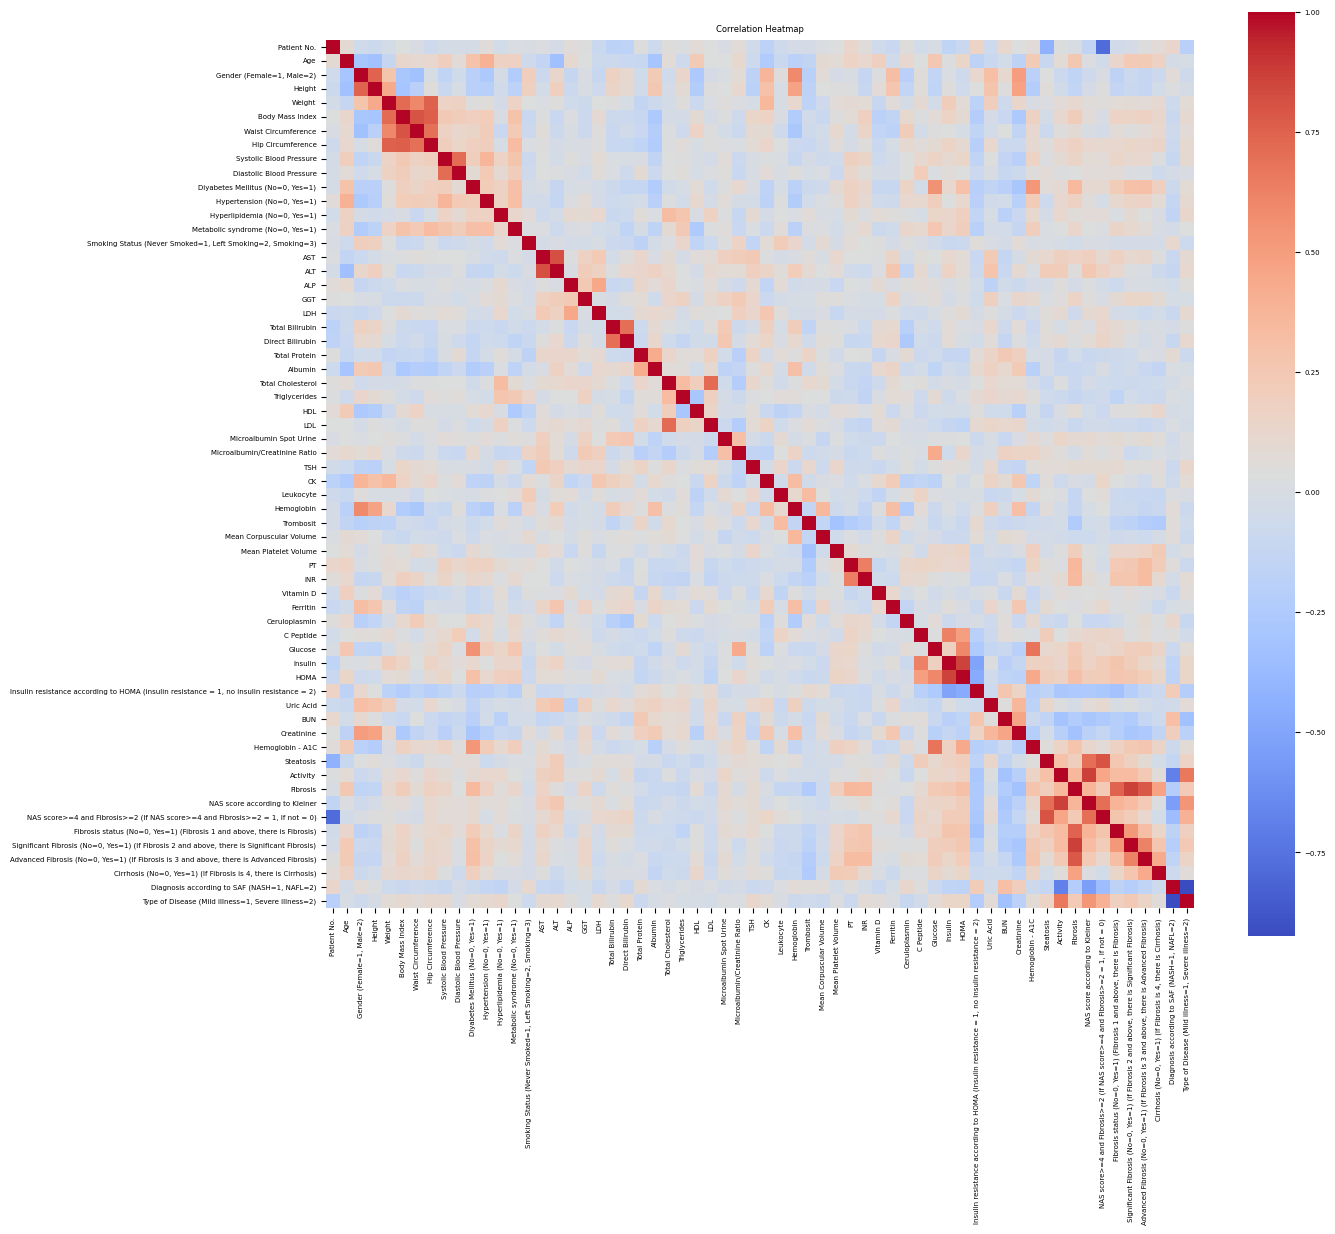

In [63]:
#Korelasyon matrisi görselleştirme
file_path = 'NAFLD.xlsx'  
data = pd.ExcelFile(file_path)
sheet1_data = data.parse('Sheet1')

numerical_data = sheet1_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.show()

Veri işlemleri


In [64]:
#Eksik değerlerin sayısı ve oranı
def miss_value_table(dataframe, na__name=False):
    n_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[n_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[n_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n\n")
    if na__name:
        return n_columns

n_columns = miss_value_table(data_frame, True)

                                                    n_miss   ratio
Microalbumin/Creatinine Ratio                          490 80.9900
CK                                                     452 74.7100
C Peptide                                              438 72.4000
Microalbumin Spot Urine                                422 69.7500
Vitamin D                                              412 68.1000
PT                                                     368 60.8300
Uric Acid                                              351 58.0200
Insulin resistance according to HOMA (insulin r...     328 54.2100
Insulin                                                328 54.2100
HOMA                                                   328 54.2100
Ceruloplasmin                                          317 52.4000
TSH                                                    312 51.5700
INR                                                    301 49.7500
BUN                                                    300 49.

In [65]:
drop__cols = [col for col in data_frame.columns if data_frame[col].isnull().sum() >= 300]
data_frame.drop(columns = drop__cols, inplace=True)

In [66]:
data_frame.drop(columns = "Patient No.",inplace=True)

In [67]:
n_columns = miss_value_table(data_frame, True)

                                                    n_miss   ratio
Total Protein                                           82 13.5500
LDH                                                     44  7.2700
Hemoglobin - A1C                                        41  6.7800
Waist Circumference                                     29  4.7900
Smoking Status (Never Smoked=1, Left Smoking=2,...      28  4.6300
Ferritin                                                17  2.8100
Mean Platelet Volume                                    14  2.3100
Hip Circumference                                        7  1.1600
Glucose                                                  4  0.6600
LDL                                                      3  0.5000
GGT                                                      3  0.5000
Mean Corpuscular Volume                                  2  0.3300
ALP                                                      1  0.1700
Triglycerides                                            1  0.

In [68]:
#Eksik değerlerin doldurdurulması
for col in n_columns:
    data_frame.loc[data_frame[col].isnull(), col] = data_frame[col].mode().iloc[0] 

data_frame.isnull().sum()

Age                                                                                            0
Gender (Female=1, Male=2)                                                                      0
Height                                                                                         0
Weight                                                                                         0
Body Mass Index                                                                                0
Waist Circumference                                                                            0
Hip Circumference                                                                              0
Systolic Blood Pressure                                                                        0
Diastolic Blood Pressure                                                                       0
Diyabetes Mellitus (No=0, Yes=1)                                                               0
Hypertension (No=0, Yes=1)    

In [69]:
cat_cols, num_cols, cat_but_car = column_names_gr(data_frame)

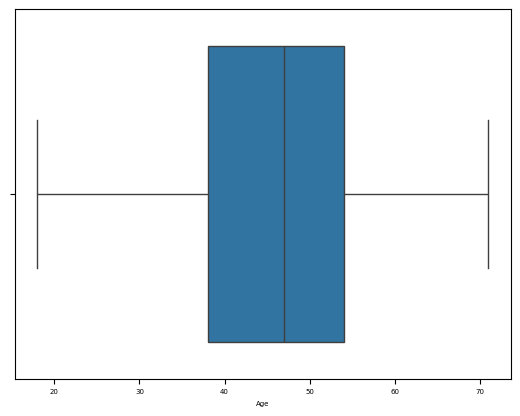

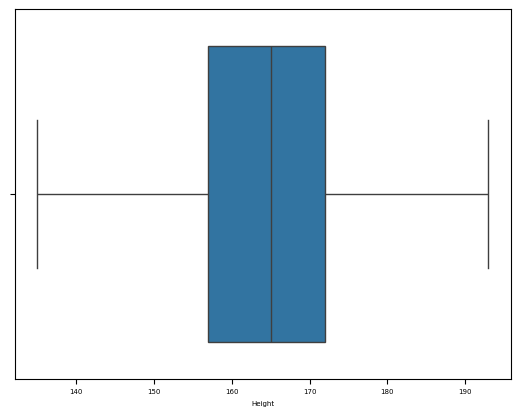

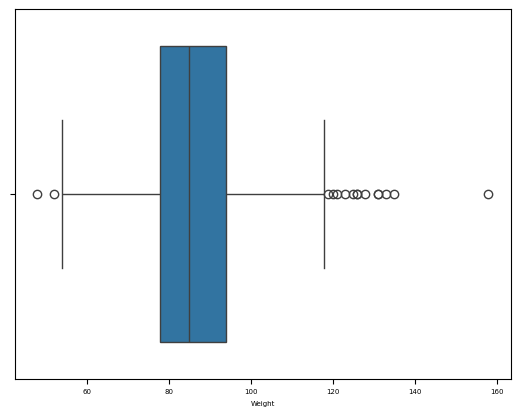

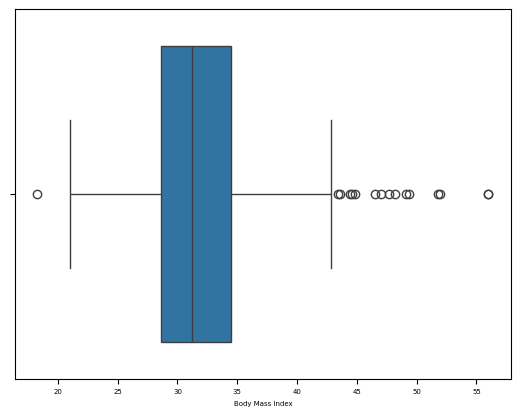

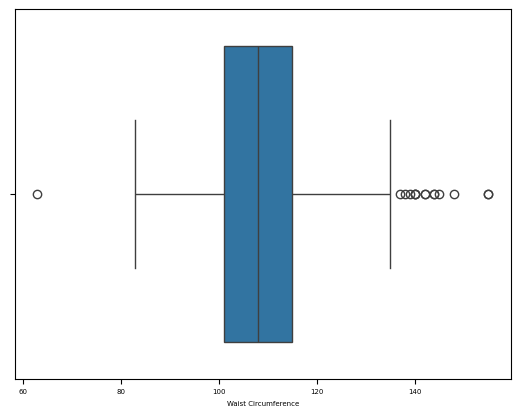

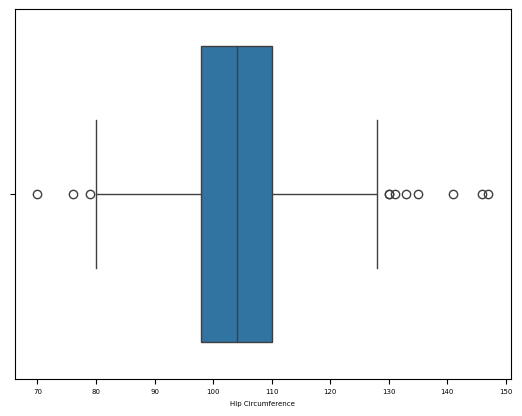

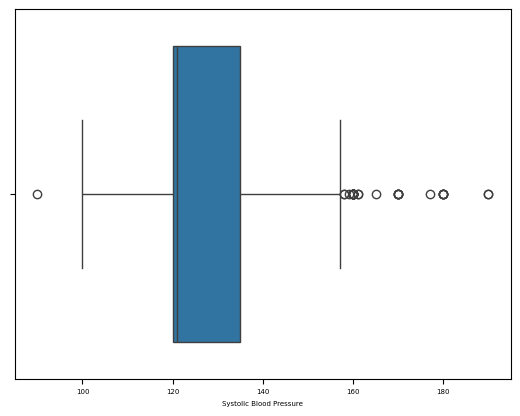

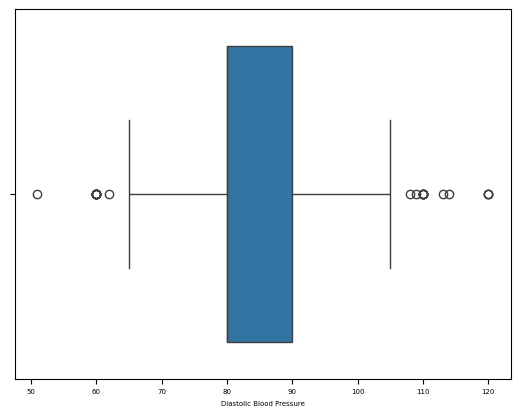

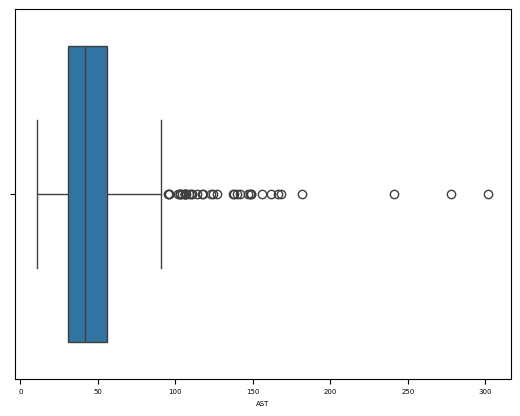

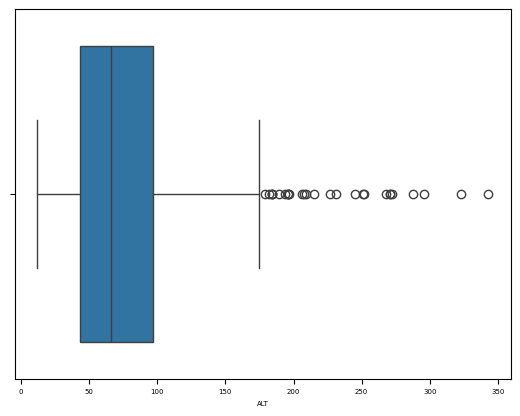

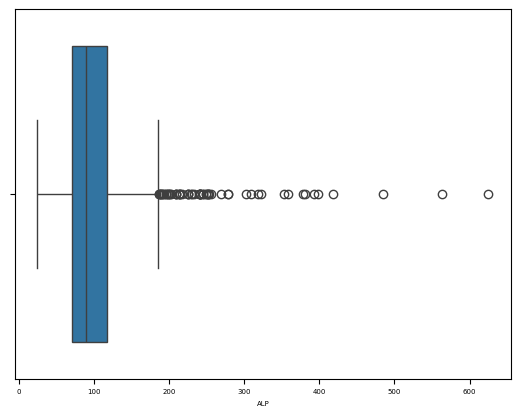

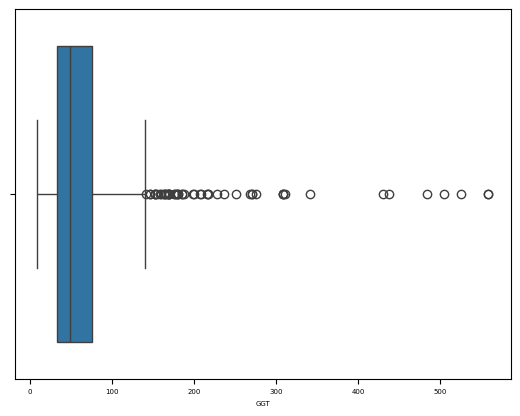

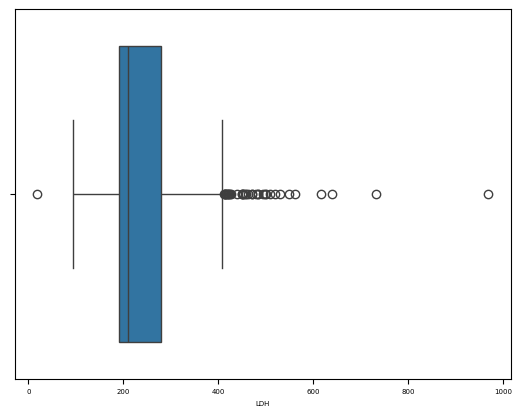

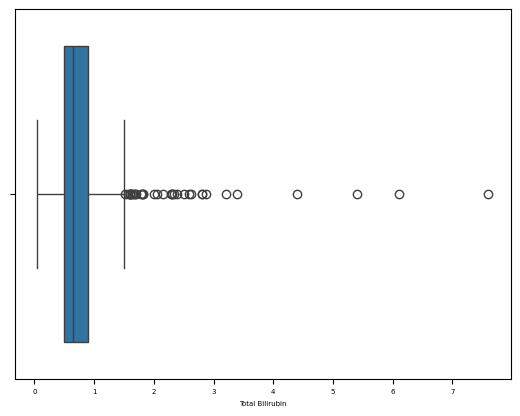

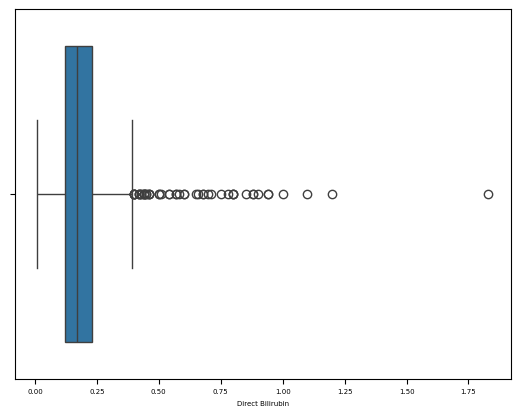

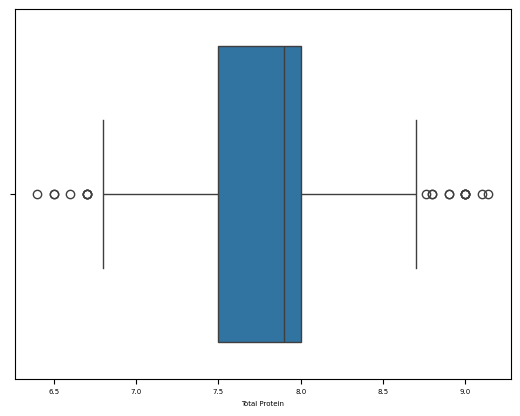

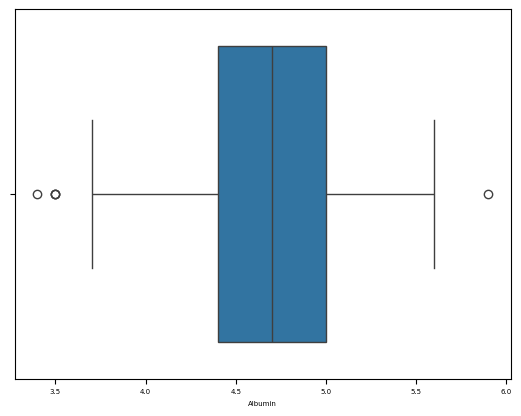

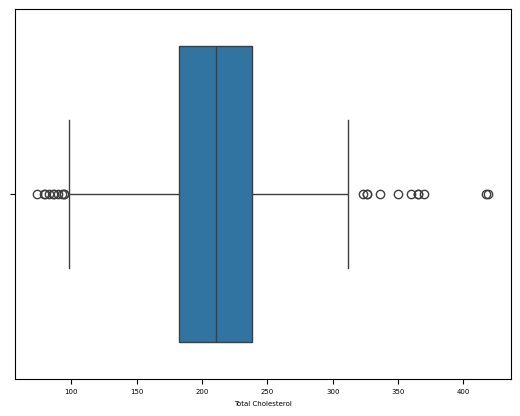

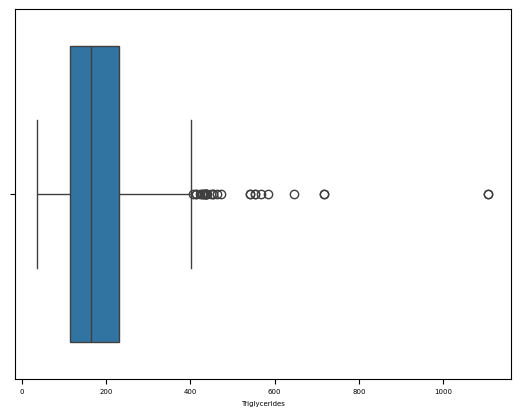

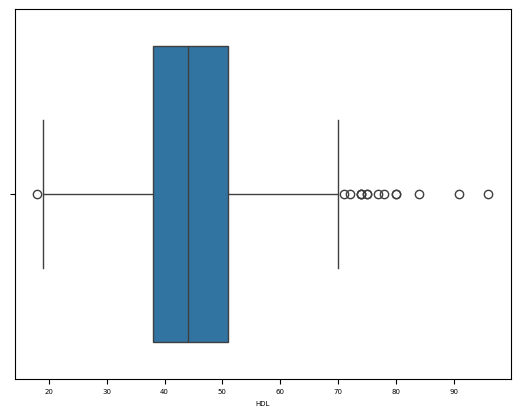

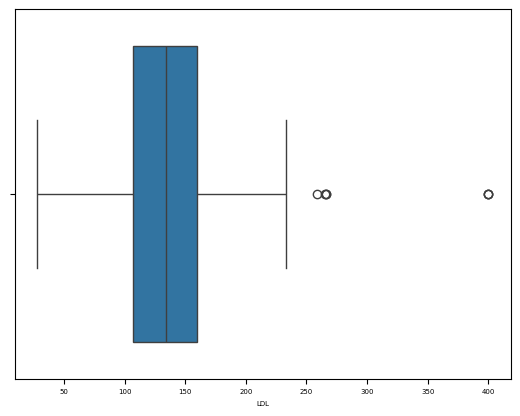

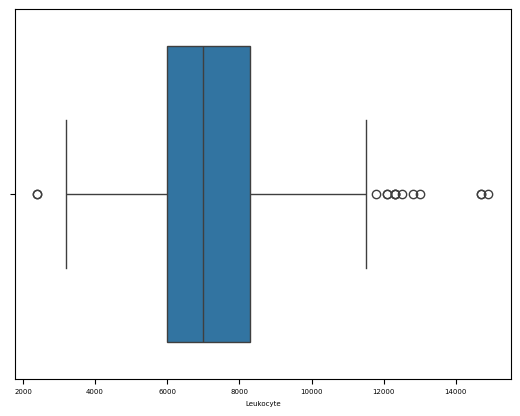

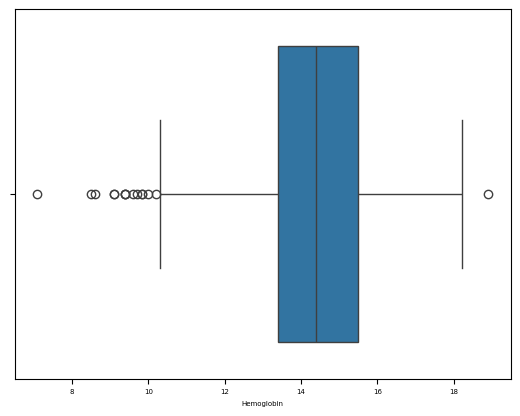

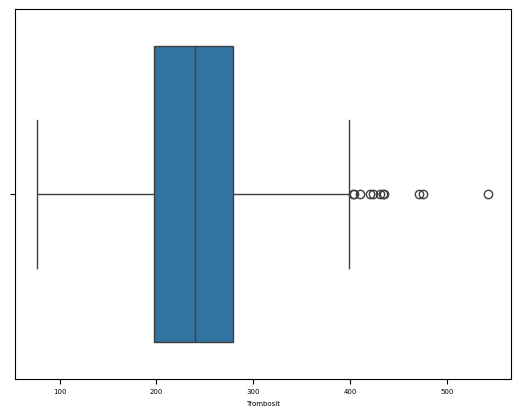

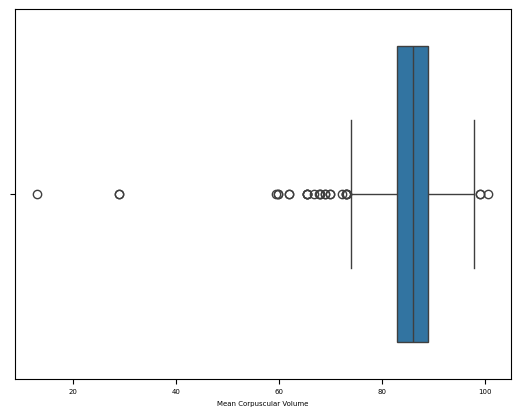

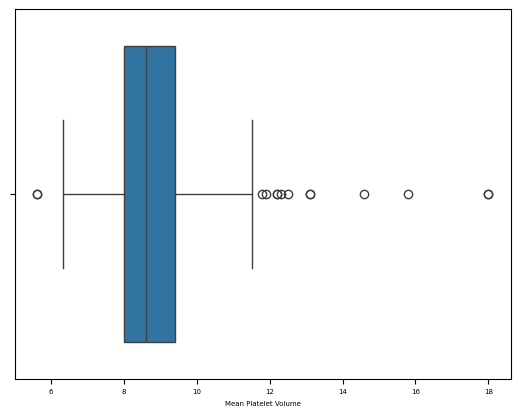

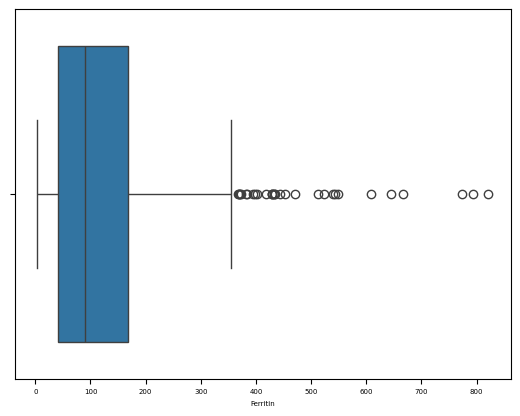

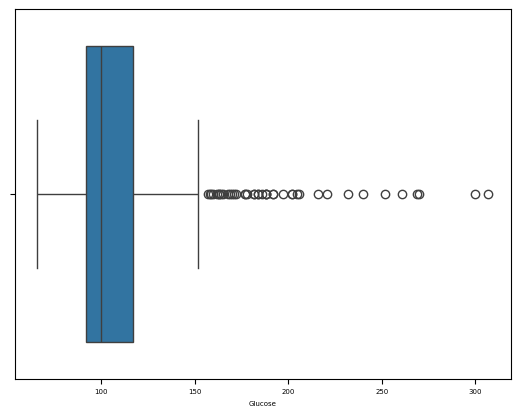

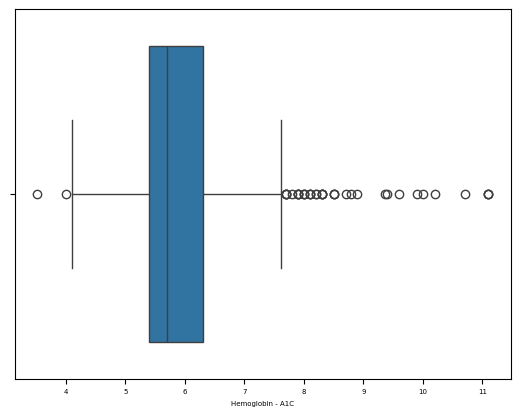

In [70]:
#Aykırı değerlerin boxplot ile görselleştirilmesi
for col in num_cols:
    sns.boxplot(x=data_frame[col])
    plt.show()

In [71]:
#Alt ve üst sınırlarının hesaplanması
def outlier_threshold(dataframe, col_name, q1=0.1, q3=0.9):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    inter_quantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * inter_quantile
    up_limit = quartile3 + 1.5 * inter_quantile
    
    return low_limit, up_limit

In [72]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(col, check_outlier(data_frame, col))

Age False
Height False
Weight True
Body Mass Index False
Waist Circumference False
Hip Circumference False
Systolic Blood Pressure False
Diastolic Blood Pressure False
AST True
ALT True
ALP True
GGT True
LDH True
Total Bilirubin True
Direct Bilirubin True
Total Protein False
Albumin False
Total Cholesterol False
Triglycerides True
HDL False
LDL True
Leukocyte False
Hemoglobin False
Trombosit False
Mean Corpuscular Volume True
Mean Platelet Volume True
Ferritin True
Glucose True
Hemoglobin - A1C True


In [73]:
#Aykırı değerlerin sınır değerlerine döndürülmesi.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for column in num_cols:
    replace_with_thresholds(data_frame, column)

C:\Users\adaro\AppData\Local\Temp\ipykernel_14124\49890990.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\adaro\AppData\Local\Temp\ipykernel_14124\49890990.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '111.09999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\adaro\AppData\Local\Temp\ipykernel_14124\49890990.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.5' has dtype incompatible with int64, please explicitly cast to a com

In [74]:
for column in num_cols:
    print(col, check_outlier(data_frame, column))

Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False


Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False
Hemoglobin - A1C False


In [75]:
#Veri setinin normalleştirilmesi
cols = [col for col in data_frame.columns if col not in ["Patient No.", "Type of Disease (Mild illness=1, Severe illness=2)"]]
scaler = StandardScaler()
data_frame[cols] = scaler.fit_transform(data_frame[cols])

In [76]:
def split(data_frame):
    y = data_frame["Type of Disease (Mild illness=1, Severe illness=2)"]
    X = data_frame.drop(["Type of Disease (Mild illness=1, Severe illness=2)"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_test, y_train, y_test

In [77]:
X_train, X_test, y_train, y_test = split(data_frame)

MODELLERİN DOĞRULUK DEĞERLERİ


In [78]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)

#Tahmin
y_pred = randomforest.predict(X_test)
y_pred_proba = randomforest.predict_proba(X_test)[:, 1] if hasattr(randomforest, "predict_proba") else None

#Doğruluk oran hesaplamaları
acc_randomforest = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of Random Forest  Classifier: {acc_randomforest}%")
print(f"Precision of Random Forest  Classifier: {precision_rf}")
print(f"Recall of Random Forest  Classifier: {recall_rf}")
print(f"F1 Score of Random Forest  Classifier: {f1_rf}")
print(f"ROC AUC of Random Forest  Classifier: {roc_auc_rf}")


Accuracy of Random Forest  Classifier: 100.0%
Precision of Random Forest  Classifier: 1.0
Recall of Random Forest  Classifier: 1.0
F1 Score of Random Forest  Classifier: 1.0
ROC AUC of Random Forest  Classifier: 1.0


In [79]:
#KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

#Tahmin
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1] if hasattr(knn, "predict_proba") else None

#Doğruluk oran hesaplamaları
acc_knn = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of KNN  Classifier: {acc_knn}%")
print(f"Precision of KNN  Classifier: {precision_knn}")
print(f"Recall of KNN  Classifier: {recall_knn}")
print(f"F1 Score of KNN  Classifier: {f1_knn}")
print(f"ROC AUC of KNN  Classifier: {roc_auc_knn}")

Accuracy of KNN  Classifier: 98.35%
Precision of KNN  Classifier: 0.875
Recall of KNN  Classifier: 0.9333333333333333
F1 Score of KNN  Classifier: 0.9032258064516129
ROC AUC of KNN  Classifier: 0.9976047904191617


In [80]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

#Tahmin
y_pred = gaussian.predict(X_test)
y_pred_proba = gaussian.predict_proba(X_test)[:, 1] if hasattr(gaussian, "predict_proba") else None

#Doğruluk oran hesaplamaları
acc_gaussian = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_gnb = precision_score(y_test, y_pred)
recall_gnb = recall_score(y_test, y_pred)
f1_gnb = f1_score(y_test, y_pred)
roc_auc_gnb = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of Gaussian Naive Bayes Classifier: {acc_gaussian}%")
print(f"Precision of Gaussian Naive Bayes Classifier: {precision_gnb}")
print(f"Recall of Gaussian Naive Bayes Classifier: {recall_gnb}")
print(f"F1 Score of Gaussian Naive Bayes Classifier: {f1_gnb}")
print(f"ROC AUC of Gaussian Naive Bayes Classifier: {roc_auc_gnb}")

Accuracy of Gaussian Naive Bayes Classifier: 97.8%
Precision of Gaussian Naive Bayes Classifier: 0.7894736842105263
Recall of Gaussian Naive Bayes Classifier: 1.0
F1 Score of Gaussian Naive Bayes Classifier: 0.8823529411764706
ROC AUC of Gaussian Naive Bayes Classifier: 0.9996007984031936


In [81]:
#Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

#Tahmin
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)[:, 1] if hasattr(svc, "predict_proba") else None

#Doğruluk oran hesaplamaları
acc_svc = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_svc = precision_score(y_test, y_pred)
recall_svc = recall_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred)
roc_auc_svc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of Support Vector Machines Classifier: {acc_svc}%")
print(f"Precision of Support Vector Machines Classifier: {precision_svc}")
print(f"Recall of Support Vector Machines Classifier: {recall_svc}")
print(f"F1 Score of Support Vector Machines Classifier: {f1_svc}")
print(f"ROC AUC of Support Vector Machines Classifier: {roc_auc_svc}")

Accuracy of Support Vector Machines Classifier: 98.9%
Precision of Support Vector Machines Classifier: 0.8823529411764706
Recall of Support Vector Machines Classifier: 1.0
F1 Score of Support Vector Machines Classifier: 0.9375
ROC AUC of Support Vector Machines Classifier: N/A


In [82]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
# Tahmin 
y_pred = decisiontree.predict(X_test)
y_pred_proba = decisiontree.predict_proba(X_test)[:, 1] if hasattr(decisiontree, "predict_proba") else None

# Doğruluk oran hesaplamaları
acc_decisiontree = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_dt = precision_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of Decision Tree Classifier: {acc_decisiontree}%")
print(f"Precision of Decision Tree Classifier: {precision_dt}")
print(f"Recall of Decision Tree Classifier: {recall_dt}")
print(f"F1 Score of Decision Tree Classifier: {f1_dt}")
print(f"ROC AUC of Decision Tree Classifier: {roc_auc_dt}")

Accuracy of Decision Tree Classifier: 100.0%
Precision of Decision Tree Classifier: 1.0
Recall of Decision Tree Classifier: 1.0
F1 Score of Decision Tree Classifier: 1.0
ROC AUC of Decision Tree Classifier: 1.0


In [83]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

#Tahmin
y_pred = gbk.predict(X_test)
y_pred_proba = gbk.predict_proba(X_test)[:, 1] if hasattr(gbk, "predict_proba") else None

#Doğruluk oran hesaplamaları
acc_gbk = round(accuracy_score(y_test, y_pred) * 100, 2)
precision_gbk = precision_score(y_test, y_pred)
recall_gbk = recall_score(y_test, y_pred)
f1_gbk = f1_score(y_test, y_pred)
roc_auc_gbk = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

print(f"Accuracy of Gradient Boosting Classifier: {acc_gbk}%")
print(f"Precision of Gradient Boosting Classifier: {precision_gbk}")
print(f"Recall of Gradient Boosting Classifier: {recall_gbk}")
print(f"F1 Score of Gradient Boosting Classifier: {f1_gbk}")
print(f"ROC AUC of Gradient Boosting Classifier: {roc_auc_gbk}")

Accuracy of Gradient Boosting Classifier: 100.0%
Precision of Gradient Boosting Classifier: 1.0
Recall of Gradient Boosting Classifier: 1.0
F1 Score of Gradient Boosting Classifier: 1.0
ROC AUC of Gradient Boosting Classifier: 1.0


SEÇİLEBİLECEK MODELLERİN DOĞRULUK DEĞERLERİNİN TABLOSU

In [84]:
#Xgboost doğruluk verileri
acc_gbk = round(accuracy_score(y_test, y_pred) * 100, 2)
precision_gbk = precision_score(y_test, y_pred)
recall_gbk = recall_score(y_test, y_pred)
f1_gbk = f1_score(y_test, y_pred)
roc_auc_gbk = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

#Random forest doğruluk verileri
acc_randomforest = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

#Decision tree doğruluk verileri
acc_decisiontree = round(accuracy_score(y_pred, y_test) * 100, 2)
precision_dt = precision_score(y_test, y_pred)
recall_dt = recall_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else "N/A"

#Tablo
data = {
    "Gradient Boosting": [acc_gbk, precision_gbk, recall_gbk, f1_gbk, roc_auc_gbk],
    "Random Forest": [acc_randomforest, precision_rf, recall_rf, f1_rf, roc_auc_rf],
    "Decision Tree": [acc_decisiontree , precision_dt, recall_dt, f1_dt, roc_auc_dt]
}

#Satır isimleri
index = ["Accuracy (%)", "Precision", "Recall", "F1 Score", "ROC AUC"]

#DataFrame oluştur
df = pd.DataFrame(data, index=index)

#Tabloyu yazdır
print("Classifier Metrics Table:")
print(df)


Classifier Metrics Table:
              Gradient Boosting  Random Forest  Decision Tree
Accuracy (%)           100.0000       100.0000       100.0000
Precision                1.0000         1.0000         1.0000
Recall                   1.0000         1.0000         1.0000
F1 Score                 1.0000         1.0000         1.0000
ROC AUC                  1.0000         1.0000         1.0000


SEÇİLEBİLECEK MODELLERİN ÖZELLİK ÖNEM GRAFİKLERİ


In [85]:
#Önem grafiği çizme fonksiyonu
def feature_importance_plot(model, X_train, model_name):
    importance = model.feature_importances_
    features = X_train.columns
    
    indices = importance.argsort()[-20:]
    plt.rcParams.update({'font.size': 5})

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices], align="center")
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel("Özellik Önemi")
    plt.title(model_name)
    plt.show()

XGBoost Özellik Önemi:



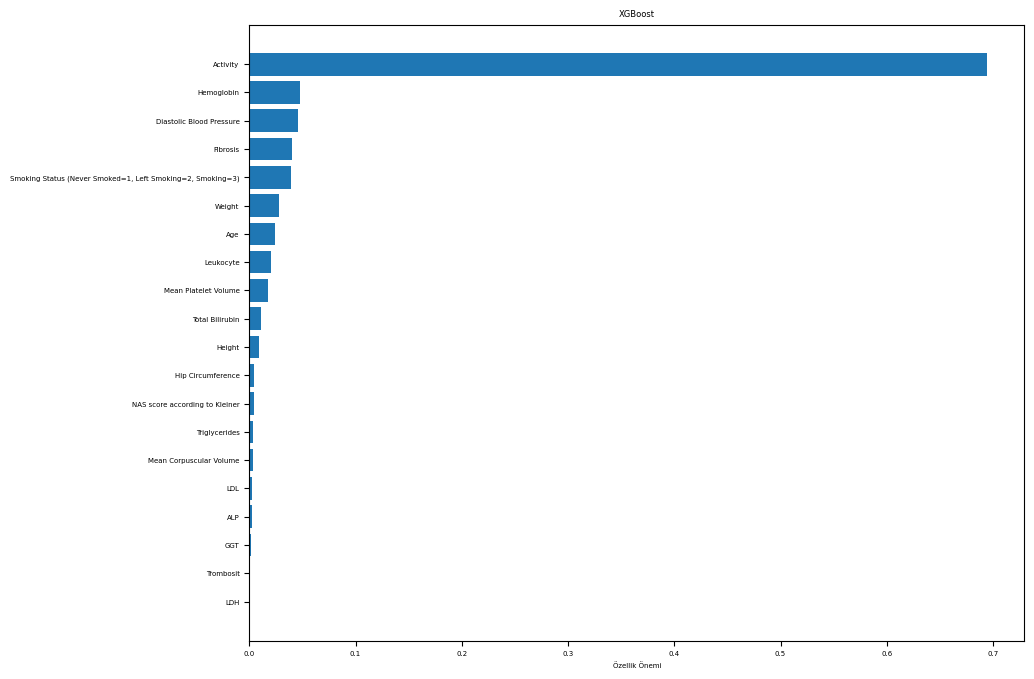

In [86]:
#XGradBoost
xgb_model = XGBClassifier(eval_metric='logloss',random_state=42)
xgb_model.fit(X_train, y_train - 1)

#Tahmin
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

#Özellik önemi
print("XGBoost Özellik Önemi:\n")
feature_importance_plot(xgb_model, pd.DataFrame(X_train, columns=X_train.columns), "XGBoost")


Random Forest Özellik Önemi:



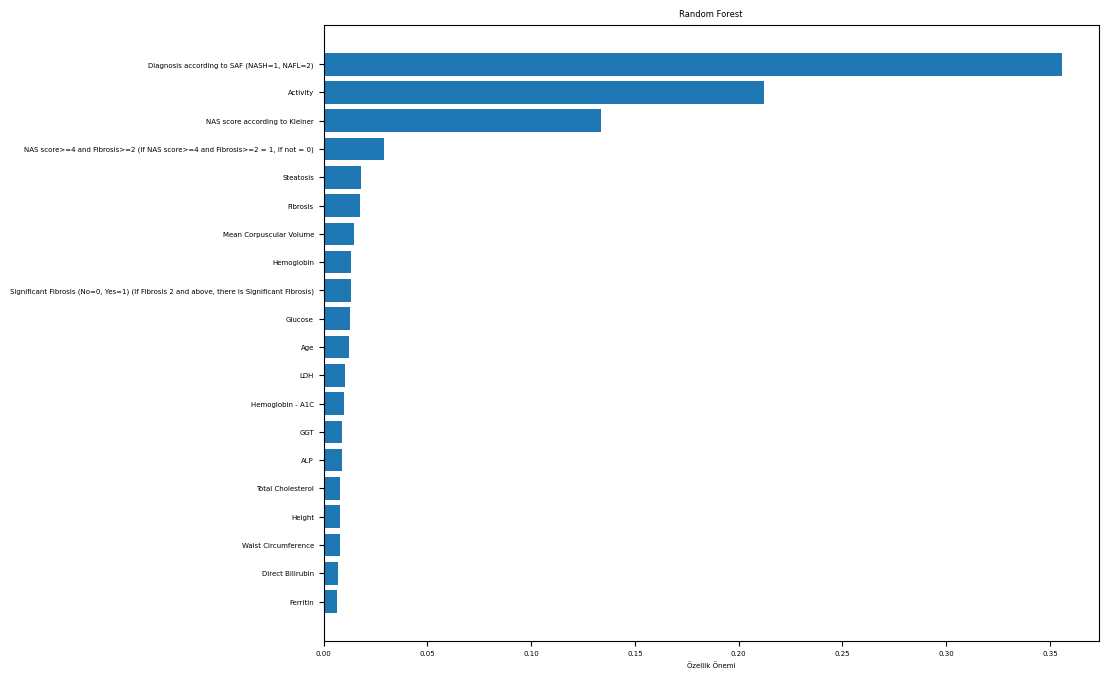

In [87]:
#Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#Tahmin
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

#Özellik önemi
print("Random Forest Özellik Önemi:\n")
feature_importance_plot(rf_model, pd.DataFrame(X_train, columns=X_train.columns), "Random Forest")

Decision Tree Özellik Önemi:



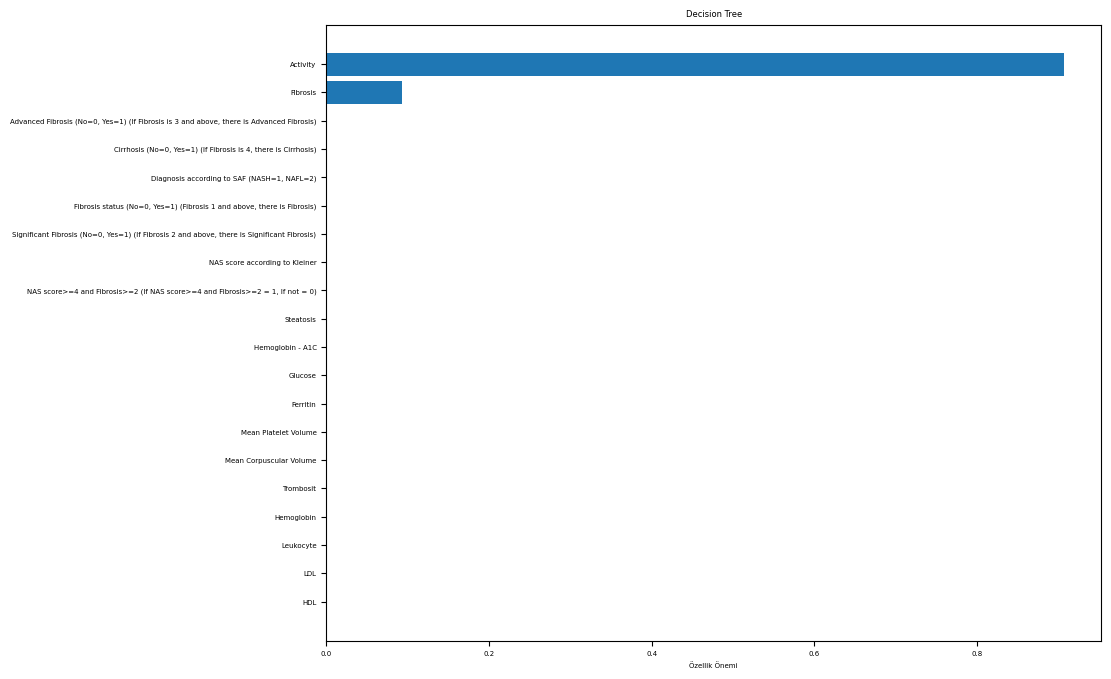

In [88]:
#Decision Tree
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)

#Tahmin 
y_pred = decisiontree.predict(X_test)
y_pred_proba = decisiontree.predict_proba(X_test)[:, 1] 

#Özellik önemi
print("Decision Tree Özellik Önemi:\n")
feature_importance_plot(decisiontree, pd.DataFrame(X_train, columns=X_train.columns), "Decision Tree")
